In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]


# set expansion degree
L=256

# load the initial ice and sea level data
sl0,ice0 = SL.get_sl_ice_data(L)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

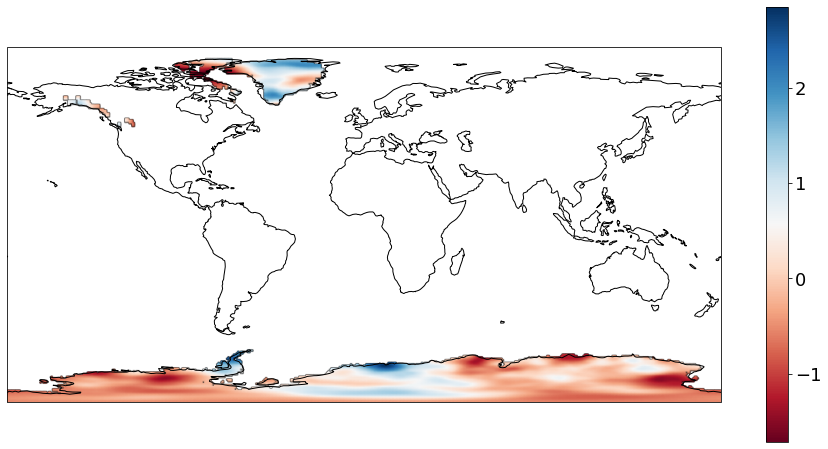

iteration =  1 relative change =  0.020290653560908825
iteration =  2 relative change =  0.001915540967499241
iteration =  3 relative change =  0.0004382188095367145
iteration =  4 relative change =  0.00013912598670992398
iteration =  5 relative change =  4.909699496715025e-05
iteration =  6 relative change =  2.0403263011183376e-05
iteration =  7 relative change =  7.890329273393891e-06
iteration =  8 relative change =  3.1558423396902665e-06
iteration =  9 relative change =  1.2424237209130272e-06
iteration =  10 relative change =  4.930868267217236e-07


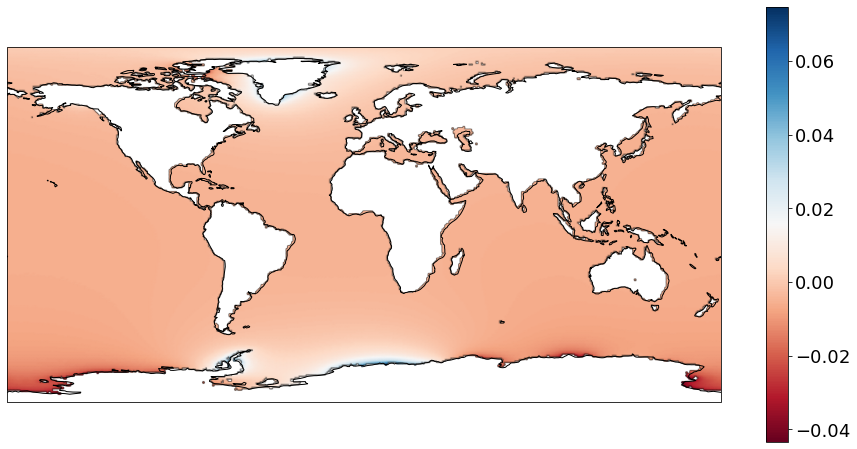

iteration =  1 relative change =  0.019897439272101174
iteration =  2 relative change =  0.001660239688400419
iteration =  3 relative change =  0.00033265783952144746
iteration =  4 relative change =  0.00014734090014299092
iteration =  5 relative change =  5.5006284025947755e-05
iteration =  6 relative change =  2.2353385549424476e-05
iteration =  7 relative change =  8.760806552673454e-06
iteration =  8 relative change =  3.489727448332196e-06
iteration =  9 relative change =  1.3799661417887474e-06
iteration =  10 relative change =  5.475746919425309e-07


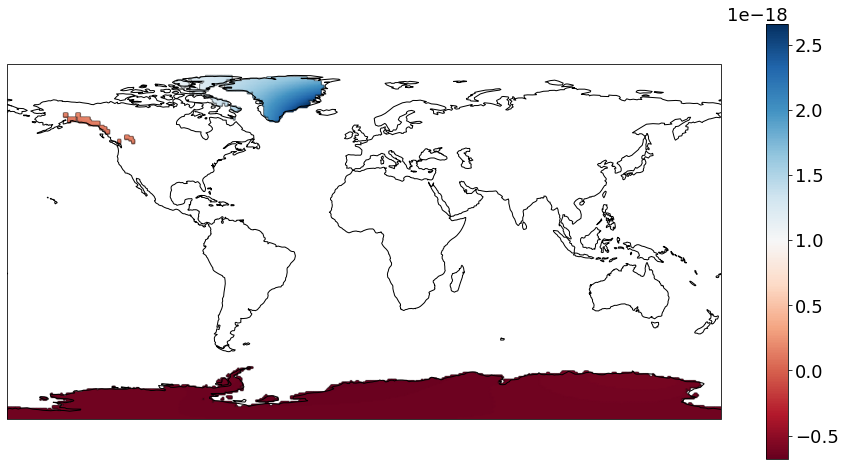

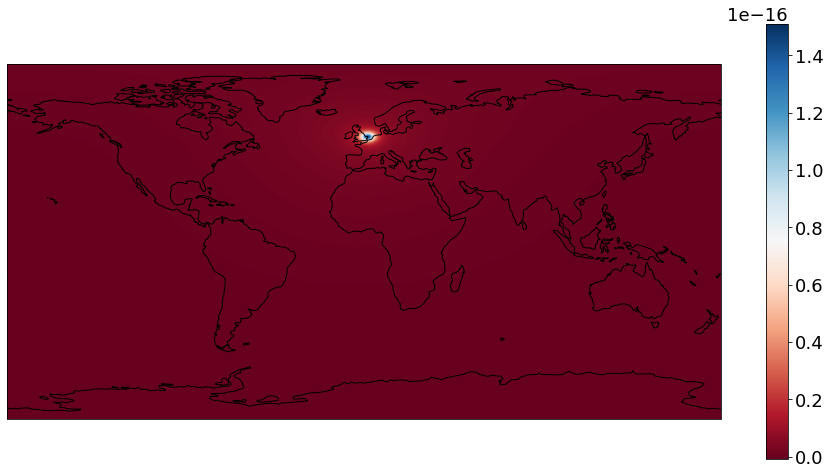

0.0022788111989069633 0.002278786656970131 1.0000107697386929


In [3]:
# set covariance for a random field
Q = SL.laplace_covariance(L,std = 1.,s = 3,mu = 0.05) 

# build a random melt geometry
ice = SL.random_field(Q)*SL.ice_mask(sl0,ice0,0.)
                          
# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*ice)

# solve the fingerprint problem
zeta  = SL.rhoi*(1-C)*ice
zeta_u = pysh.SHGrid.from_zeros(lmax=L,grid='GLQ')
zeta_phi = pysh.SHGrid.from_zeros(lmax=L,grid='GLQ')
lv = np.zeros(2)
sl,u,phi,om,psi = SL.generalised_fingerprint(C,zeta,zeta_u,zeta_phi,lv)
ocean_mask = SL.ocean_mask(sl0,ice0)
SL.plot(ocean_mask*sl)

# set the observation point and set the adjoint loads
lats = np.zeros(1)
lons = np.zeros(1)
lats[0] =  52.48
lons[0] =  1.75
zeta_d        = 0*SL.point_load(L,lats,lons,angle = 2)
zeta_u_d      = 1*SL.point_load(L,lats,lons,angle = 2) 
zeta_phi_d    = 0*SL.point_load(L,lats,lons,angle = 5) 
lv_d  = np.zeros(2)
lv_d[1] = 0*-SL.g

# act the adjoint load on the sea level to get the observation
J =   SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(lv_d,om)/SL.g

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,lv_d)
SL.plot(SL.ice_mask(sl0,ice0)*sl_d)
SL.plot(sl_d)

# act the load on the adjoint sea level
J2 =   SL.surface_integral(zeta*sl_d)          

print(J,J2,J/J2)

